<a href="https://colab.research.google.com/github/tugce999/audio-classification/blob/main/human_audio_classification_train_model_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import librosa
import librosa.display
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from tensorflow import keras
import datetime
from tensorflow.keras.utils import to_categorical
from tensorboard.plugins.hparams import api as hp

# LOAD DATA

In [ ]:
# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = r"data_voices.json"

with open(DATA_PATH, "r") as fp:
        data = json.load(fp)

# convert lists to numpy arrays
X = np.array(data["mfcc"],dtype=object)
y = np.array(data["labels"])


print("Data succesfully loaded!")

Data succesfully loaded!


In [ ]:
X = np.asarray(X).astype('float32')
y = to_categorical(y)

In [ ]:
y

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0.

# SPLIT DATA (TEST,TRAIN,VALID)

In [ ]:
TEST_SIZE = 0.25
VALIDATION_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=VALIDATION_SIZE)

# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(72, 13, 13, 1)
(30, 13, 13, 1)
(18, 13, 13, 1)


In [ ]:
print(y_train.shape)
print(y_test.shape)
print(y_validation.shape)

(72, 6)
(30, 6)
(18, 6)


# TRAIN MODEL WITH TENSORBOARD HYPERPARAMETER TUNING

In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.4))
METRIC_ACCURACY = 'accuracy'

In [ ]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
def train_test_model(hparams):
    model = keras.Sequential()

    input_shape=(X_train.shape[1], X_train.shape[2], 1)
    # 1st conv layer
    model.add(keras.layers.Conv2D(hparams[HP_NUM_UNITS], (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.Dropout(hparams[HP_DROPOUT]))
    #model.add(keras.layers.BatchNormalization()) # Batch normalization overfite sebep oluyor

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.Dropout(hparams[HP_DROPOUT]))
    #model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.Dropout(hparams[HP_DROPOUT]))
    #model.add(keras.layers.BatchNormalization())


    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))

    # output layer
    model.add(keras.layers.Dense(6, activation='softmax'))
    
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                    batch_size=32, 
                    epochs=1,
                    callbacks=[tensorboard_callback])
    #model.summary()
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    
    return test_acc

In [ ]:
def run(run_dir,hparams):
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
        model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                    batch_size=32, 
                    epochs=1000,
                    callbacks=[tensorboard_callback,hp.KerasCallback(log_dir, hparams),])

In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.2}
3/3 [==============================] - 1s 161ms/step - loss: 43.7899 - accuracy: 0.0556 - val_loss: 15.9556 - val_accuracy: 0.0000e+00
1/1 - 0s - loss: 16.3361 - accuracy: 0.0000e+00
Epoch 1/1000
3/3 [==============================] - 0s 125ms/step - loss: 6.2228 - accuracy: 0.2917 - val_loss: 1.2138 - val_accuracy: 0.5000
Epoch 2/1000
3/3 [==============================] - 0s 25ms/step - loss: 6.2928 - accuracy: 0.2361 - val_loss: 1.2244 - val_accuracy: 0.5000
Epoch 3/1000
3/3 [==============================] - 0s 20ms/step - loss: 7.2148 - accuracy: 0.2222 - val_loss: 1.2352 - val_accuracy: 0.5000
Epoch 4/1000
3/3 [==============================] - 0s 18ms/step - loss: 7.3025 - accuracy: 0.2917 - val_loss: 1.2436 - val_accuracy: 0.5000
Epoch 5/1000
3/3 [==============================] - 0s 16ms/step - loss: 6.4318 - accuracy: 0.2639 - val_loss: 1.2549 - val_accuracy: 0.5000
Epoch 6/1000
3/3 [==============================] -

3/3 [==============================] - 0s 17ms/step - loss: 4.2047 - accuracy: 0.3889 - val_loss: 1.3562 - val_accuracy: 0.3889
Epoch 58/1000
3/3 [==============================] - 0s 16ms/step - loss: 4.8259 - accuracy: 0.2500 - val_loss: 1.3608 - val_accuracy: 0.3889
Epoch 59/1000
3/3 [==============================] - 0s 17ms/step - loss: 3.8653 - accuracy: 0.2778 - val_loss: 1.3663 - val_accuracy: 0.3889
Epoch 60/1000
3/3 [==============================] - 0s 18ms/step - loss: 4.2628 - accuracy: 0.2500 - val_loss: 1.3683 - val_accuracy: 0.3889
Epoch 61/1000
3/3 [==============================] - 0s 16ms/step - loss: 4.0101 - accuracy: 0.2917 - val_loss: 1.3681 - val_accuracy: 0.3889
Epoch 62/1000
3/3 [==============================] - 0s 16ms/step - loss: 4.0189 - accuracy: 0.2639 - val_loss: 1.3702 - val_accuracy: 0.3889
Epoch 63/1000
3/3 [==============================] - 0s 17ms/step - loss: 4.4891 - accuracy: 0.2500 - val_loss: 1.3748 - val_accuracy: 0.3889
Epoch 64/1000
3/3 [=

Epoch 115/1000
3/3 [==============================] - 0s 16ms/step - loss: 3.2921 - accuracy: 0.2500 - val_loss: 1.4568 - val_accuracy: 0.3333
Epoch 116/1000
3/3 [==============================] - 0s 15ms/step - loss: 3.4935 - accuracy: 0.1806 - val_loss: 1.4570 - val_accuracy: 0.3333
Epoch 117/1000
3/3 [==============================] - 0s 20ms/step - loss: 4.0816 - accuracy: 0.2917 - val_loss: 1.4574 - val_accuracy: 0.3333
Epoch 118/1000
3/3 [==============================] - 0s 18ms/step - loss: 3.5360 - accuracy: 0.2222 - val_loss: 1.4584 - val_accuracy: 0.3333
Epoch 119/1000
3/3 [==============================] - 0s 15ms/step - loss: 3.5539 - accuracy: 0.1667 - val_loss: 1.4597 - val_accuracy: 0.3333
Epoch 120/1000
3/3 [==============================] - 0s 17ms/step - loss: 2.8363 - accuracy: 0.2639 - val_loss: 1.4628 - val_accuracy: 0.3333
Epoch 121/1000
3/3 [==============================] - 0s 16ms/step - loss: 3.8782 - accuracy: 0.2500 - val_loss: 1.4641 - val_accuracy: 0.3333

3/3 [==============================] - 0s 22ms/step - loss: 1.8849 - accuracy: 0.3472 - val_loss: 1.5508 - val_accuracy: 0.5000
Epoch 230/1000
3/3 [==============================] - 0s 21ms/step - loss: 2.1038 - accuracy: 0.3750 - val_loss: 1.5512 - val_accuracy: 0.5000
Epoch 231/1000
3/3 [==============================] - 0s 22ms/step - loss: 2.0156 - accuracy: 0.3611 - val_loss: 1.5513 - val_accuracy: 0.5000
Epoch 232/1000
3/3 [==============================] - 0s 22ms/step - loss: 2.2190 - accuracy: 0.2361 - val_loss: 1.5508 - val_accuracy: 0.5000
Epoch 233/1000
3/3 [==============================] - 0s 28ms/step - loss: 2.4789 - accuracy: 0.1806 - val_loss: 1.5505 - val_accuracy: 0.5000
Epoch 234/1000
3/3 [==============================] - 0s 30ms/step - loss: 1.9506 - accuracy: 0.3611 - val_loss: 1.5514 - val_accuracy: 0.5000
Epoch 235/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.3195 - accuracy: 0.2917 - val_loss: 1.5523 - val_accuracy: 0.5000
Epoch 236/1000

3/3 [==============================] - 0s 41ms/step - loss: 1.9211 - accuracy: 0.2361 - val_loss: 1.5435 - val_accuracy: 0.6111
Epoch 344/1000
3/3 [==============================] - 0s 55ms/step - loss: 1.5603 - accuracy: 0.2778 - val_loss: 1.5425 - val_accuracy: 0.6667
Epoch 345/1000
3/3 [==============================] - 0s 35ms/step - loss: 1.9389 - accuracy: 0.3194 - val_loss: 1.5417 - val_accuracy: 0.6667
Epoch 346/1000
3/3 [==============================] - 0s 37ms/step - loss: 1.9946 - accuracy: 0.2361 - val_loss: 1.5410 - val_accuracy: 0.6111
Epoch 347/1000
3/3 [==============================] - 0s 38ms/step - loss: 1.9956 - accuracy: 0.4167 - val_loss: 1.5412 - val_accuracy: 0.6111
Epoch 348/1000
3/3 [==============================] - 0s 39ms/step - loss: 2.0766 - accuracy: 0.2500 - val_loss: 1.5424 - val_accuracy: 0.6111
Epoch 349/1000
3/3 [==============================] - 0s 60ms/step - loss: 1.8053 - accuracy: 0.3472 - val_loss: 1.5439 - val_accuracy: 0.6111
Epoch 350/1000

3/3 [==============================] - 0s 31ms/step - loss: 2.0340 - accuracy: 0.2778 - val_loss: 1.5370 - val_accuracy: 0.5000
Epoch 458/1000
3/3 [==============================] - 0s 31ms/step - loss: 1.6502 - accuracy: 0.3889 - val_loss: 1.5361 - val_accuracy: 0.5556
Epoch 459/1000
3/3 [==============================] - 0s 35ms/step - loss: 1.6876 - accuracy: 0.3750 - val_loss: 1.5349 - val_accuracy: 0.6111
Epoch 460/1000
3/3 [==============================] - 0s 35ms/step - loss: 1.5853 - accuracy: 0.4028 - val_loss: 1.5344 - val_accuracy: 0.6111
Epoch 461/1000
3/3 [==============================] - 0s 34ms/step - loss: 1.8156 - accuracy: 0.3889 - val_loss: 1.5343 - val_accuracy: 0.6111
Epoch 462/1000
3/3 [==============================] - 0s 32ms/step - loss: 1.6541 - accuracy: 0.4306 - val_loss: 1.5339 - val_accuracy: 0.6667
Epoch 463/1000
3/3 [==============================] - 0s 26ms/step - loss: 1.8633 - accuracy: 0.3333 - val_loss: 1.5330 - val_accuracy: 0.6667
Epoch 464/1000

3/3 [==============================] - 0s 34ms/step - loss: 1.5236 - accuracy: 0.4306 - val_loss: 1.5034 - val_accuracy: 0.5556
Epoch 572/1000
3/3 [==============================] - 0s 33ms/step - loss: 1.6343 - accuracy: 0.2917 - val_loss: 1.5027 - val_accuracy: 0.5556
Epoch 573/1000
3/3 [==============================] - 0s 37ms/step - loss: 1.4777 - accuracy: 0.3889 - val_loss: 1.5008 - val_accuracy: 0.5556
Epoch 574/1000
3/3 [==============================] - 0s 33ms/step - loss: 1.6466 - accuracy: 0.3889 - val_loss: 1.4987 - val_accuracy: 0.5556
Epoch 575/1000
3/3 [==============================] - 0s 32ms/step - loss: 1.4861 - accuracy: 0.3750 - val_loss: 1.4970 - val_accuracy: 0.5556
Epoch 576/1000
3/3 [==============================] - 0s 32ms/step - loss: 1.4965 - accuracy: 0.3472 - val_loss: 1.4959 - val_accuracy: 0.5556
Epoch 577/1000
3/3 [==============================] - 0s 34ms/step - loss: 1.6262 - accuracy: 0.4167 - val_loss: 1.4945 - val_accuracy: 0.5556
Epoch 578/1000

3/3 [==============================] - 0s 31ms/step - loss: 1.4642 - accuracy: 0.4028 - val_loss: 1.4448 - val_accuracy: 0.6111
Epoch 686/1000
3/3 [==============================] - 0s 32ms/step - loss: 1.3245 - accuracy: 0.5000 - val_loss: 1.4448 - val_accuracy: 0.6111
Epoch 687/1000
3/3 [==============================] - 0s 31ms/step - loss: 1.4915 - accuracy: 0.3750 - val_loss: 1.4451 - val_accuracy: 0.6111
Epoch 688/1000
3/3 [==============================] - 0s 33ms/step - loss: 1.4274 - accuracy: 0.3472 - val_loss: 1.4450 - val_accuracy: 0.6111
Epoch 689/1000
3/3 [==============================] - 0s 36ms/step - loss: 1.4814 - accuracy: 0.4444 - val_loss: 1.4454 - val_accuracy: 0.6111
Epoch 690/1000
3/3 [==============================] - 0s 32ms/step - loss: 1.4220 - accuracy: 0.4028 - val_loss: 1.4457 - val_accuracy: 0.6111
Epoch 691/1000
3/3 [==============================] - 0s 29ms/step - loss: 1.5324 - accuracy: 0.3889 - val_loss: 1.4459 - val_accuracy: 0.6111
Epoch 692/1000

3/3 [==============================] - 0s 32ms/step - loss: 1.2243 - accuracy: 0.4583 - val_loss: 1.3698 - val_accuracy: 0.5556
Epoch 800/1000
3/3 [==============================] - 0s 32ms/step - loss: 1.3759 - accuracy: 0.4444 - val_loss: 1.3655 - val_accuracy: 0.6111
Epoch 801/1000
3/3 [==============================] - 0s 35ms/step - loss: 1.3297 - accuracy: 0.4722 - val_loss: 1.3594 - val_accuracy: 0.6111
Epoch 802/1000
3/3 [==============================] - 0s 32ms/step - loss: 1.2671 - accuracy: 0.5000 - val_loss: 1.3532 - val_accuracy: 0.6111
Epoch 803/1000
3/3 [==============================] - 0s 35ms/step - loss: 1.4806 - accuracy: 0.4028 - val_loss: 1.3491 - val_accuracy: 0.6111
Epoch 804/1000
3/3 [==============================] - 0s 37ms/step - loss: 1.4807 - accuracy: 0.3750 - val_loss: 1.3479 - val_accuracy: 0.6111
Epoch 805/1000
3/3 [==============================] - 0s 35ms/step - loss: 1.4280 - accuracy: 0.5139 - val_loss: 1.3491 - val_accuracy: 0.6111
Epoch 806/1000

3/3 [==============================] - 0s 33ms/step - loss: 1.1583 - accuracy: 0.5417 - val_loss: 1.2712 - val_accuracy: 0.7222
Epoch 914/1000
3/3 [==============================] - 0s 34ms/step - loss: 1.3391 - accuracy: 0.4583 - val_loss: 1.2707 - val_accuracy: 0.7222
Epoch 915/1000
3/3 [==============================] - 0s 29ms/step - loss: 1.3450 - accuracy: 0.4028 - val_loss: 1.2701 - val_accuracy: 0.7222
Epoch 916/1000
3/3 [==============================] - 0s 30ms/step - loss: 1.3742 - accuracy: 0.4583 - val_loss: 1.2696 - val_accuracy: 0.7222
Epoch 917/1000
3/3 [==============================] - 0s 34ms/step - loss: 1.3509 - accuracy: 0.4722 - val_loss: 1.2685 - val_accuracy: 0.7222
Epoch 918/1000
3/3 [==============================] - 0s 38ms/step - loss: 1.2719 - accuracy: 0.4028 - val_loss: 1.2672 - val_accuracy: 0.7222
Epoch 919/1000
3/3 [==============================] - 0s 31ms/step - loss: 1.3839 - accuracy: 0.4028 - val_loss: 1.2668 - val_accuracy: 0.7222
Epoch 920/1000

Epoch 26/1000
3/3 [==============================] - 0s 30ms/step - loss: 1.1498 - accuracy: 0.6111 - val_loss: 1.2063 - val_accuracy: 0.6667
Epoch 27/1000
3/3 [==============================] - 0s 33ms/step - loss: 1.0909 - accuracy: 0.6111 - val_loss: 1.2066 - val_accuracy: 0.7222
Epoch 28/1000
3/3 [==============================] - 0s 44ms/step - loss: 1.0870 - accuracy: 0.6111 - val_loss: 1.2066 - val_accuracy: 0.7222
Epoch 29/1000
3/3 [==============================] - 0s 31ms/step - loss: 1.1445 - accuracy: 0.5972 - val_loss: 1.2069 - val_accuracy: 0.7222
Epoch 30/1000
3/3 [==============================] - 0s 35ms/step - loss: 1.0810 - accuracy: 0.5694 - val_loss: 1.2068 - val_accuracy: 0.7222
Epoch 31/1000
3/3 [==============================] - 0s 29ms/step - loss: 1.0808 - accuracy: 0.5556 - val_loss: 1.2053 - val_accuracy: 0.7222
Epoch 32/1000
3/3 [==============================] - 0s 31ms/step - loss: 1.2550 - accuracy: 0.5556 - val_loss: 1.2034 - val_accuracy: 0.7778
Epoch 

Epoch 84/1000
3/3 [==============================] - 0s 34ms/step - loss: 1.2566 - accuracy: 0.4444 - val_loss: 1.1445 - val_accuracy: 0.7222
Epoch 85/1000
3/3 [==============================] - 0s 35ms/step - loss: 0.9920 - accuracy: 0.5972 - val_loss: 1.1439 - val_accuracy: 0.7222
Epoch 86/1000
3/3 [==============================] - 0s 33ms/step - loss: 1.1033 - accuracy: 0.5278 - val_loss: 1.1434 - val_accuracy: 0.7222
Epoch 87/1000
3/3 [==============================] - 0s 34ms/step - loss: 1.2160 - accuracy: 0.5000 - val_loss: 1.1435 - val_accuracy: 0.7222
Epoch 88/1000
3/3 [==============================] - 0s 33ms/step - loss: 1.2984 - accuracy: 0.5278 - val_loss: 1.1438 - val_accuracy: 0.7222
Epoch 89/1000
3/3 [==============================] - 0s 32ms/step - loss: 1.0236 - accuracy: 0.5556 - val_loss: 1.1430 - val_accuracy: 0.7222
Epoch 90/1000
3/3 [==============================] - 0s 35ms/step - loss: 1.1308 - accuracy: 0.5833 - val_loss: 1.1418 - val_accuracy: 0.7222
Epoch 

3/3 [==============================] - 0s 33ms/step - loss: 1.2866 - accuracy: 0.5000 - val_loss: 1.1061 - val_accuracy: 0.7222
Epoch 199/1000
3/3 [==============================] - 0s 29ms/step - loss: 1.0851 - accuracy: 0.5694 - val_loss: 1.1074 - val_accuracy: 0.7222
Epoch 200/1000
3/3 [==============================] - 0s 33ms/step - loss: 1.1637 - accuracy: 0.5278 - val_loss: 1.1084 - val_accuracy: 0.7222
Epoch 201/1000
3/3 [==============================] - 0s 36ms/step - loss: 1.0868 - accuracy: 0.5972 - val_loss: 1.1088 - val_accuracy: 0.7222
Epoch 202/1000
3/3 [==============================] - 0s 35ms/step - loss: 0.9858 - accuracy: 0.6528 - val_loss: 1.1087 - val_accuracy: 0.7222
Epoch 203/1000
3/3 [==============================] - 0s 32ms/step - loss: 1.1150 - accuracy: 0.5694 - val_loss: 1.1079 - val_accuracy: 0.7222
Epoch 204/1000
3/3 [==============================] - 0s 36ms/step - loss: 0.9716 - accuracy: 0.5833 - val_loss: 1.1075 - val_accuracy: 0.7222
Epoch 205/1000

3/3 [==============================] - 0s 35ms/step - loss: 1.1192 - accuracy: 0.5972 - val_loss: 1.0545 - val_accuracy: 0.6111
Epoch 313/1000
3/3 [==============================] - 0s 32ms/step - loss: 0.8617 - accuracy: 0.6528 - val_loss: 1.0541 - val_accuracy: 0.6667
Epoch 314/1000
3/3 [==============================] - 0s 32ms/step - loss: 0.8754 - accuracy: 0.5833 - val_loss: 1.0531 - val_accuracy: 0.6667
Epoch 315/1000
3/3 [==============================] - 0s 30ms/step - loss: 0.9766 - accuracy: 0.6389 - val_loss: 1.0520 - val_accuracy: 0.7222
Epoch 316/1000
3/3 [==============================] - 0s 36ms/step - loss: 0.8989 - accuracy: 0.6111 - val_loss: 1.0510 - val_accuracy: 0.7222
Epoch 317/1000
3/3 [==============================] - 0s 33ms/step - loss: 0.8807 - accuracy: 0.6111 - val_loss: 1.0498 - val_accuracy: 0.7222
Epoch 318/1000
3/3 [==============================] - 0s 31ms/step - loss: 0.9733 - accuracy: 0.6528 - val_loss: 1.0491 - val_accuracy: 0.7222
Epoch 319/1000

3/3 [==============================] - 0s 30ms/step - loss: 1.0830 - accuracy: 0.5694 - val_loss: 1.0231 - val_accuracy: 0.6667
Epoch 427/1000
3/3 [==============================] - 0s 29ms/step - loss: 0.9893 - accuracy: 0.6806 - val_loss: 1.0228 - val_accuracy: 0.6667
Epoch 428/1000
3/3 [==============================] - 0s 38ms/step - loss: 1.0267 - accuracy: 0.6111 - val_loss: 1.0217 - val_accuracy: 0.6111
Epoch 429/1000
3/3 [==============================] - 0s 33ms/step - loss: 0.8058 - accuracy: 0.7222 - val_loss: 1.0203 - val_accuracy: 0.6111
Epoch 430/1000
3/3 [==============================] - 0s 26ms/step - loss: 0.9124 - accuracy: 0.6667 - val_loss: 1.0184 - val_accuracy: 0.6111
Epoch 431/1000
3/3 [==============================] - 0s 33ms/step - loss: 1.0262 - accuracy: 0.6250 - val_loss: 1.0170 - val_accuracy: 0.6111
Epoch 432/1000
3/3 [==============================] - 0s 34ms/step - loss: 0.9541 - accuracy: 0.6389 - val_loss: 1.0167 - val_accuracy: 0.6111
Epoch 433/1000

3/3 [==============================] - 0s 35ms/step - loss: 1.0124 - accuracy: 0.6528 - val_loss: 0.9529 - val_accuracy: 0.7778
Epoch 541/1000
3/3 [==============================] - 0s 30ms/step - loss: 0.8510 - accuracy: 0.6667 - val_loss: 0.9528 - val_accuracy: 0.7778
Epoch 542/1000
3/3 [==============================] - 0s 33ms/step - loss: 0.8844 - accuracy: 0.6389 - val_loss: 0.9522 - val_accuracy: 0.7778
Epoch 543/1000
3/3 [==============================] - 0s 29ms/step - loss: 0.8453 - accuracy: 0.6389 - val_loss: 0.9509 - val_accuracy: 0.7222
Epoch 544/1000
3/3 [==============================] - 0s 37ms/step - loss: 0.8464 - accuracy: 0.6389 - val_loss: 0.9497 - val_accuracy: 0.7222
Epoch 545/1000
3/3 [==============================] - 0s 35ms/step - loss: 0.8770 - accuracy: 0.6528 - val_loss: 0.9491 - val_accuracy: 0.7222
Epoch 546/1000
3/3 [==============================] - 0s 33ms/step - loss: 0.6676 - accuracy: 0.7361 - val_loss: 0.9485 - val_accuracy: 0.7222
Epoch 547/1000

3/3 [==============================] - 0s 33ms/step - loss: 0.7937 - accuracy: 0.7361 - val_loss: 0.9257 - val_accuracy: 0.6667
Epoch 655/1000
3/3 [==============================] - 0s 38ms/step - loss: 0.7496 - accuracy: 0.7222 - val_loss: 0.9260 - val_accuracy: 0.6667
Epoch 656/1000
3/3 [==============================] - 0s 37ms/step - loss: 0.6241 - accuracy: 0.7361 - val_loss: 0.9257 - val_accuracy: 0.6667
Epoch 657/1000
3/3 [==============================] - 0s 35ms/step - loss: 0.6781 - accuracy: 0.7222 - val_loss: 0.9268 - val_accuracy: 0.6667
Epoch 658/1000
3/3 [==============================] - 0s 29ms/step - loss: 0.9097 - accuracy: 0.6806 - val_loss: 0.9292 - val_accuracy: 0.6667
Epoch 659/1000
3/3 [==============================] - 0s 41ms/step - loss: 0.8984 - accuracy: 0.6806 - val_loss: 0.9318 - val_accuracy: 0.6667
Epoch 660/1000
3/3 [==============================] - 0s 37ms/step - loss: 0.7990 - accuracy: 0.6806 - val_loss: 0.9349 - val_accuracy: 0.6667
Epoch 661/1000

3/3 [==============================] - 0s 30ms/step - loss: 0.6829 - accuracy: 0.7639 - val_loss: 0.8775 - val_accuracy: 0.7778
Epoch 769/1000
3/3 [==============================] - 0s 31ms/step - loss: 0.5884 - accuracy: 0.7222 - val_loss: 0.8729 - val_accuracy: 0.7778
Epoch 770/1000
3/3 [==============================] - 0s 35ms/step - loss: 0.6399 - accuracy: 0.7500 - val_loss: 0.8695 - val_accuracy: 0.8333
Epoch 771/1000
3/3 [==============================] - 0s 34ms/step - loss: 0.6408 - accuracy: 0.7917 - val_loss: 0.8677 - val_accuracy: 0.8333
Epoch 772/1000
3/3 [==============================] - 0s 33ms/step - loss: 0.8447 - accuracy: 0.7500 - val_loss: 0.8670 - val_accuracy: 0.8333
Epoch 773/1000
3/3 [==============================] - 0s 31ms/step - loss: 0.6492 - accuracy: 0.6806 - val_loss: 0.8671 - val_accuracy: 0.8333
Epoch 774/1000
3/3 [==============================] - 0s 36ms/step - loss: 0.7292 - accuracy: 0.7500 - val_loss: 0.8671 - val_accuracy: 0.8333
Epoch 775/1000

3/3 [==============================] - 0s 40ms/step - loss: 0.8309 - accuracy: 0.6667 - val_loss: 0.8349 - val_accuracy: 0.6667
Epoch 883/1000
3/3 [==============================] - 0s 32ms/step - loss: 0.6350 - accuracy: 0.7500 - val_loss: 0.8333 - val_accuracy: 0.6667
Epoch 884/1000
3/3 [==============================] - 0s 26ms/step - loss: 0.6742 - accuracy: 0.7500 - val_loss: 0.8322 - val_accuracy: 0.7222
Epoch 885/1000
3/3 [==============================] - 0s 35ms/step - loss: 0.7956 - accuracy: 0.5972 - val_loss: 0.8291 - val_accuracy: 0.7222
Epoch 886/1000
3/3 [==============================] - 0s 35ms/step - loss: 0.5765 - accuracy: 0.7361 - val_loss: 0.8264 - val_accuracy: 0.7222
Epoch 887/1000
3/3 [==============================] - 0s 38ms/step - loss: 0.7803 - accuracy: 0.6944 - val_loss: 0.8258 - val_accuracy: 0.7222
Epoch 888/1000
3/3 [==============================] - 0s 30ms/step - loss: 0.5943 - accuracy: 0.7639 - val_loss: 0.8246 - val_accuracy: 0.7222
Epoch 889/1000

3/3 [==============================] - 0s 44ms/step - loss: 0.4819 - accuracy: 0.8194 - val_loss: 0.7478 - val_accuracy: 0.8333
Epoch 997/1000
3/3 [==============================] - 0s 40ms/step - loss: 0.6128 - accuracy: 0.7639 - val_loss: 0.7479 - val_accuracy: 0.8333
Epoch 998/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.5121 - accuracy: 0.8056 - val_loss: 0.7497 - val_accuracy: 0.8333
Epoch 999/1000
3/3 [==============================] - 0s 46ms/step - loss: 0.5329 - accuracy: 0.7917 - val_loss: 0.7503 - val_accuracy: 0.8333
Epoch 1000/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.5453 - accuracy: 0.8056 - val_loss: 0.7494 - val_accuracy: 0.8333
--- Starting trial: run-2
{'num_units': 32, 'dropout': 0.2}
3/3 [==============================] - 3s 493ms/step - loss: 24.6481 - accuracy: 0.2639 - val_loss: 11.8965 - val_accuracy: 0.2778
1/1 - 0s - loss: 13.7870 - accuracy: 0.2000
Epoch 1/1000
3/3 [==============================] - 1s 259ms/ste

Epoch 110/1000
3/3 [==============================] - 0s 49ms/step - loss: 0.5348 - accuracy: 0.8333 - val_loss: 0.7094 - val_accuracy: 0.8333
Epoch 111/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.6130 - accuracy: 0.7917 - val_loss: 0.7073 - val_accuracy: 0.8333
Epoch 112/1000
3/3 [==============================] - 0s 47ms/step - loss: 0.5397 - accuracy: 0.7778 - val_loss: 0.7056 - val_accuracy: 0.8333
Epoch 113/1000
3/3 [==============================] - 0s 44ms/step - loss: 0.6012 - accuracy: 0.7639 - val_loss: 0.7038 - val_accuracy: 0.8333
Epoch 114/1000
3/3 [==============================] - 0s 43ms/step - loss: 0.5061 - accuracy: 0.7639 - val_loss: 0.7025 - val_accuracy: 0.8333
Epoch 115/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.5502 - accuracy: 0.8472 - val_loss: 0.7006 - val_accuracy: 0.8333
Epoch 116/1000
3/3 [==============================] - 0s 75ms/step - loss: 0.5270 - accuracy: 0.8194 - val_loss: 0.6984 - val_accuracy: 0.7778

3/3 [==============================] - 0s 31ms/step - loss: 0.5103 - accuracy: 0.8056 - val_loss: 0.6755 - val_accuracy: 0.8333
Epoch 225/1000
3/3 [==============================] - 0s 34ms/step - loss: 0.4908 - accuracy: 0.8333 - val_loss: 0.6767 - val_accuracy: 0.8333
Epoch 226/1000
3/3 [==============================] - 0s 42ms/step - loss: 0.5412 - accuracy: 0.7222 - val_loss: 0.6782 - val_accuracy: 0.8333
Epoch 227/1000
3/3 [==============================] - 0s 39ms/step - loss: 0.4493 - accuracy: 0.8472 - val_loss: 0.6802 - val_accuracy: 0.8333
Epoch 228/1000
3/3 [==============================] - 0s 34ms/step - loss: 0.6775 - accuracy: 0.6944 - val_loss: 0.6819 - val_accuracy: 0.8333
Epoch 229/1000
3/3 [==============================] - 0s 36ms/step - loss: 0.5911 - accuracy: 0.7639 - val_loss: 0.6836 - val_accuracy: 0.8333
Epoch 230/1000
3/3 [==============================] - 0s 34ms/step - loss: 0.4682 - accuracy: 0.7917 - val_loss: 0.6838 - val_accuracy: 0.8333
Epoch 231/1000

3/3 [==============================] - 0s 39ms/step - loss: 0.3507 - accuracy: 0.8611 - val_loss: 0.6504 - val_accuracy: 0.8333
Epoch 339/1000
3/3 [==============================] - 0s 45ms/step - loss: 0.4878 - accuracy: 0.8472 - val_loss: 0.6467 - val_accuracy: 0.8333
Epoch 340/1000
3/3 [==============================] - 0s 43ms/step - loss: 0.5843 - accuracy: 0.8333 - val_loss: 0.6446 - val_accuracy: 0.8333
Epoch 341/1000
3/3 [==============================] - 0s 107ms/step - loss: 0.4533 - accuracy: 0.8750 - val_loss: 0.6433 - val_accuracy: 0.8333
Epoch 342/1000
3/3 [==============================] - 0s 52ms/step - loss: 0.4027 - accuracy: 0.8056 - val_loss: 0.6419 - val_accuracy: 0.8333
Epoch 343/1000
3/3 [==============================] - 0s 53ms/step - loss: 0.5215 - accuracy: 0.7778 - val_loss: 0.6408 - val_accuracy: 0.8333
Epoch 344/1000
3/3 [==============================] - 0s 54ms/step - loss: 0.4452 - accuracy: 0.7917 - val_loss: 0.6403 - val_accuracy: 0.8333
Epoch 345/100

3/3 [==============================] - 0s 33ms/step - loss: 0.4101 - accuracy: 0.7917 - val_loss: 0.5606 - val_accuracy: 0.8333
Epoch 453/1000
3/3 [==============================] - 0s 32ms/step - loss: 0.3621 - accuracy: 0.8750 - val_loss: 0.5621 - val_accuracy: 0.8333
Epoch 454/1000
3/3 [==============================] - 0s 31ms/step - loss: 0.3385 - accuracy: 0.8750 - val_loss: 0.5638 - val_accuracy: 0.8333
Epoch 455/1000
3/3 [==============================] - 0s 35ms/step - loss: 0.5816 - accuracy: 0.7917 - val_loss: 0.5670 - val_accuracy: 0.8333
Epoch 456/1000
3/3 [==============================] - 0s 34ms/step - loss: 0.6326 - accuracy: 0.8056 - val_loss: 0.5693 - val_accuracy: 0.8333
Epoch 457/1000
3/3 [==============================] - 0s 32ms/step - loss: 0.4366 - accuracy: 0.8333 - val_loss: 0.5707 - val_accuracy: 0.8333
Epoch 458/1000
3/3 [==============================] - 0s 32ms/step - loss: 0.7702 - accuracy: 0.7917 - val_loss: 0.5726 - val_accuracy: 0.8333
Epoch 459/1000

3/3 [==============================] - 0s 36ms/step - loss: 0.4436 - accuracy: 0.8194 - val_loss: 0.5733 - val_accuracy: 0.8333
Epoch 567/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.5599 - accuracy: 0.8611 - val_loss: 0.5730 - val_accuracy: 0.8333
Epoch 568/1000
3/3 [==============================] - 0s 43ms/step - loss: 0.6182 - accuracy: 0.8056 - val_loss: 0.5732 - val_accuracy: 0.8333
Epoch 569/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.3618 - accuracy: 0.8750 - val_loss: 0.5722 - val_accuracy: 0.8333
Epoch 570/1000
3/3 [==============================] - 0s 76ms/step - loss: 0.4036 - accuracy: 0.8333 - val_loss: 0.5712 - val_accuracy: 0.8333
Epoch 571/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.3785 - accuracy: 0.8889 - val_loss: 0.5696 - val_accuracy: 0.8333
Epoch 572/1000
3/3 [==============================] - 0s 52ms/step - loss: 0.4032 - accuracy: 0.8472 - val_loss: 0.5682 - val_accuracy: 0.8333
Epoch 573/1000

3/3 [==============================] - 0s 33ms/step - loss: 0.4149 - accuracy: 0.8750 - val_loss: 0.5626 - val_accuracy: 0.8333
Epoch 681/1000
3/3 [==============================] - 0s 41ms/step - loss: 0.4623 - accuracy: 0.8472 - val_loss: 0.5666 - val_accuracy: 0.8333
Epoch 682/1000
3/3 [==============================] - 0s 31ms/step - loss: 0.3387 - accuracy: 0.8889 - val_loss: 0.5694 - val_accuracy: 0.8333
Epoch 683/1000
3/3 [==============================] - 0s 25ms/step - loss: 0.4612 - accuracy: 0.7917 - val_loss: 0.5709 - val_accuracy: 0.8333
Epoch 684/1000
3/3 [==============================] - 0s 29ms/step - loss: 0.4559 - accuracy: 0.8472 - val_loss: 0.5727 - val_accuracy: 0.8333
Epoch 685/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.2473 - accuracy: 0.9028 - val_loss: 0.5758 - val_accuracy: 0.8333
Epoch 686/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.6473 - accuracy: 0.8056 - val_loss: 0.5757 - val_accuracy: 0.8333
Epoch 687/1000

3/3 [==============================] - 0s 20ms/step - loss: 0.3394 - accuracy: 0.8472 - val_loss: 0.5621 - val_accuracy: 0.8333
Epoch 795/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.2779 - accuracy: 0.8889 - val_loss: 0.5632 - val_accuracy: 0.8333
Epoch 796/1000
3/3 [==============================] - 0s 23ms/step - loss: 0.2201 - accuracy: 0.9028 - val_loss: 0.5623 - val_accuracy: 0.8333
Epoch 797/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.2356 - accuracy: 0.9167 - val_loss: 0.5607 - val_accuracy: 0.8333
Epoch 798/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.4389 - accuracy: 0.8333 - val_loss: 0.5626 - val_accuracy: 0.8333
Epoch 799/1000
3/3 [==============================] - 0s 22ms/step - loss: 0.3171 - accuracy: 0.9167 - val_loss: 0.5628 - val_accuracy: 0.8333
Epoch 800/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.4099 - accuracy: 0.8333 - val_loss: 0.5619 - val_accuracy: 0.8333
Epoch 801/1000

3/3 [==============================] - 0s 17ms/step - loss: 0.6001 - accuracy: 0.8611 - val_loss: 0.4846 - val_accuracy: 0.8333
Epoch 909/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.3039 - accuracy: 0.9028 - val_loss: 0.4832 - val_accuracy: 0.8333
Epoch 910/1000
3/3 [==============================] - 0s 22ms/step - loss: 0.3132 - accuracy: 0.8889 - val_loss: 0.4818 - val_accuracy: 0.8333
Epoch 911/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.3932 - accuracy: 0.8472 - val_loss: 0.4810 - val_accuracy: 0.8333
Epoch 912/1000
3/3 [==============================] - 0s 22ms/step - loss: 0.3900 - accuracy: 0.8194 - val_loss: 0.4803 - val_accuracy: 0.8333
Epoch 913/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.2494 - accuracy: 0.9306 - val_loss: 0.4790 - val_accuracy: 0.8333
Epoch 914/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.2403 - accuracy: 0.9306 - val_loss: 0.4763 - val_accuracy: 0.8333
Epoch 915/1000

3/3 [==============================] - 0s 17ms/step - loss: 0.2995 - accuracy: 0.9167 - val_loss: 0.4605 - val_accuracy: 0.8333
Epoch 21/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.2701 - accuracy: 0.9028 - val_loss: 0.4603 - val_accuracy: 0.8333
Epoch 22/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.2499 - accuracy: 0.9167 - val_loss: 0.4594 - val_accuracy: 0.8333
Epoch 23/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.4265 - accuracy: 0.8472 - val_loss: 0.4598 - val_accuracy: 0.8333
Epoch 24/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.2829 - accuracy: 0.8889 - val_loss: 0.4606 - val_accuracy: 0.8333
Epoch 25/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.3212 - accuracy: 0.9028 - val_loss: 0.4608 - val_accuracy: 0.8333
Epoch 26/1000
3/3 [==============================] - 0s 29ms/step - loss: 0.2567 - accuracy: 0.9167 - val_loss: 0.4604 - val_accuracy: 0.8333
Epoch 27/1000
3/3 [=

Epoch 78/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.4961 - accuracy: 0.8333 - val_loss: 0.4472 - val_accuracy: 0.8333
Epoch 79/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.2312 - accuracy: 0.9444 - val_loss: 0.4449 - val_accuracy: 0.8333
Epoch 80/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.3781 - accuracy: 0.8611 - val_loss: 0.4433 - val_accuracy: 0.8333
Epoch 81/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.2501 - accuracy: 0.9167 - val_loss: 0.4400 - val_accuracy: 0.8333
Epoch 82/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.2588 - accuracy: 0.8889 - val_loss: 0.4367 - val_accuracy: 0.8333
Epoch 83/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.2871 - accuracy: 0.8889 - val_loss: 0.4328 - val_accuracy: 0.8333
Epoch 84/1000
3/3 [==============================] - 0s 23ms/step - loss: 0.3314 - accuracy: 0.8472 - val_loss: 0.4311 - val_accuracy: 0.8333
Epoch 

3/3 [==============================] - 0s 19ms/step - loss: 0.2579 - accuracy: 0.8889 - val_loss: 0.4372 - val_accuracy: 0.8333
Epoch 193/1000
3/3 [==============================] - 0s 23ms/step - loss: 0.2859 - accuracy: 0.8889 - val_loss: 0.4356 - val_accuracy: 0.8333
Epoch 194/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.3556 - accuracy: 0.8889 - val_loss: 0.4344 - val_accuracy: 0.8333
Epoch 195/1000
3/3 [==============================] - 0s 108ms/step - loss: 0.2691 - accuracy: 0.8611 - val_loss: 0.4332 - val_accuracy: 0.8333
Epoch 196/1000
3/3 [==============================] - 0s 26ms/step - loss: 0.2337 - accuracy: 0.9167 - val_loss: 0.4322 - val_accuracy: 0.8333
Epoch 197/1000
3/3 [==============================] - 0s 22ms/step - loss: 0.2336 - accuracy: 0.8750 - val_loss: 0.4325 - val_accuracy: 0.8333
Epoch 198/1000
3/3 [==============================] - 0s 22ms/step - loss: 0.3761 - accuracy: 0.8333 - val_loss: 0.4315 - val_accuracy: 0.8333
Epoch 199/100

3/3 [==============================] - 0s 25ms/step - loss: 0.2871 - accuracy: 0.8750 - val_loss: 0.4054 - val_accuracy: 0.8333
Epoch 307/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.3893 - accuracy: 0.8889 - val_loss: 0.4022 - val_accuracy: 0.8333
Epoch 308/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.1718 - accuracy: 0.9167 - val_loss: 0.3976 - val_accuracy: 0.8333
Epoch 309/1000
3/3 [==============================] - 0s 23ms/step - loss: 0.1865 - accuracy: 0.9167 - val_loss: 0.3935 - val_accuracy: 0.8333
Epoch 310/1000
3/3 [==============================] - 0s 23ms/step - loss: 0.2548 - accuracy: 0.9028 - val_loss: 0.3901 - val_accuracy: 0.8333
Epoch 311/1000
3/3 [==============================] - 0s 22ms/step - loss: 0.3237 - accuracy: 0.9028 - val_loss: 0.3896 - val_accuracy: 0.8333
Epoch 312/1000
3/3 [==============================] - 0s 22ms/step - loss: 0.3633 - accuracy: 0.8472 - val_loss: 0.3925 - val_accuracy: 0.8333
Epoch 313/1000

3/3 [==============================] - 0s 21ms/step - loss: 0.2010 - accuracy: 0.9583 - val_loss: 0.3941 - val_accuracy: 0.8889
Epoch 421/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.1721 - accuracy: 0.9444 - val_loss: 0.3938 - val_accuracy: 0.8889
Epoch 422/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.2170 - accuracy: 0.9306 - val_loss: 0.3937 - val_accuracy: 0.8333
Epoch 423/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.3053 - accuracy: 0.8889 - val_loss: 0.3944 - val_accuracy: 0.8333
Epoch 424/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.1921 - accuracy: 0.9167 - val_loss: 0.3951 - val_accuracy: 0.8333
Epoch 425/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.2684 - accuracy: 0.9306 - val_loss: 0.3953 - val_accuracy: 0.8333
Epoch 426/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.4342 - accuracy: 0.8472 - val_loss: 0.3928 - val_accuracy: 0.8333
Epoch 427/1000

3/3 [==============================] - 0s 21ms/step - loss: 0.2195 - accuracy: 0.9028 - val_loss: 0.3709 - val_accuracy: 0.8889
Epoch 535/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.2379 - accuracy: 0.8889 - val_loss: 0.3729 - val_accuracy: 0.8889
Epoch 536/1000
3/3 [==============================] - 0s 23ms/step - loss: 0.2976 - accuracy: 0.8889 - val_loss: 0.3745 - val_accuracy: 0.8889
Epoch 537/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.2608 - accuracy: 0.9306 - val_loss: 0.3761 - val_accuracy: 0.8889
Epoch 538/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.1593 - accuracy: 0.9583 - val_loss: 0.3772 - val_accuracy: 0.8889
Epoch 539/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.2238 - accuracy: 0.9444 - val_loss: 0.3784 - val_accuracy: 0.8889
Epoch 540/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.2557 - accuracy: 0.9167 - val_loss: 0.3760 - val_accuracy: 0.8889
Epoch 541/1000

3/3 [==============================] - 0s 18ms/step - loss: 0.3102 - accuracy: 0.8750 - val_loss: 0.3269 - val_accuracy: 0.8889
Epoch 649/1000
3/3 [==============================] - 0s 23ms/step - loss: 0.1613 - accuracy: 0.9444 - val_loss: 0.3308 - val_accuracy: 0.8889
Epoch 650/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.0929 - accuracy: 0.9722 - val_loss: 0.3333 - val_accuracy: 0.8889
Epoch 651/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.2236 - accuracy: 0.9028 - val_loss: 0.3351 - val_accuracy: 0.8889
Epoch 652/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.3073 - accuracy: 0.9167 - val_loss: 0.3347 - val_accuracy: 0.8889
Epoch 653/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0981 - accuracy: 0.9722 - val_loss: 0.3337 - val_accuracy: 0.8889
Epoch 654/1000
3/3 [==============================] - 0s 27ms/step - loss: 0.1892 - accuracy: 0.9306 - val_loss: 0.3324 - val_accuracy: 0.8889
Epoch 655/1000

3/3 [==============================] - 0s 21ms/step - loss: 0.2168 - accuracy: 0.9167 - val_loss: 0.3523 - val_accuracy: 0.8889
Epoch 706/1000
3/3 [==============================] - 0s 23ms/step - loss: 0.2012 - accuracy: 0.9167 - val_loss: 0.3489 - val_accuracy: 0.8889
Epoch 707/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.2708 - accuracy: 0.9028 - val_loss: 0.3473 - val_accuracy: 0.8889
Epoch 708/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.2728 - accuracy: 0.8750 - val_loss: 0.3475 - val_accuracy: 0.8889
Epoch 709/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.1180 - accuracy: 0.9583 - val_loss: 0.3499 - val_accuracy: 0.8889
Epoch 710/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.2223 - accuracy: 0.9583 - val_loss: 0.3520 - val_accuracy: 0.8889
Epoch 711/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.4894 - accuracy: 0.8750 - val_loss: 0.3562 - val_accuracy: 0.8889
Epoch 712/1000

3/3 [==============================] - 0s 21ms/step - loss: 0.2122 - accuracy: 0.9444 - val_loss: 0.3285 - val_accuracy: 0.8889
Epoch 820/1000
3/3 [==============================] - 0s 22ms/step - loss: 0.2094 - accuracy: 0.9028 - val_loss: 0.3290 - val_accuracy: 0.8889
Epoch 821/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.2080 - accuracy: 0.9028 - val_loss: 0.3297 - val_accuracy: 0.8889
Epoch 822/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.2974 - accuracy: 0.9167 - val_loss: 0.3313 - val_accuracy: 0.8889
Epoch 823/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.1048 - accuracy: 0.9722 - val_loss: 0.3336 - val_accuracy: 0.8889
Epoch 824/1000
3/3 [==============================] - 0s 37ms/step - loss: 0.2231 - accuracy: 0.9306 - val_loss: 0.3342 - val_accuracy: 0.8889
Epoch 825/1000
3/3 [==============================] - 0s 23ms/step - loss: 0.1722 - accuracy: 0.9167 - val_loss: 0.3337 - val_accuracy: 0.8889
Epoch 826/1000

3/3 [==============================] - 0s 75ms/step - loss: 0.1760 - accuracy: 0.9167 - val_loss: 0.3230 - val_accuracy: 0.8889
Epoch 934/1000
3/3 [==============================] - 0s 33ms/step - loss: 0.1300 - accuracy: 0.9583 - val_loss: 0.3217 - val_accuracy: 0.8889
Epoch 935/1000
3/3 [==============================] - 0s 42ms/step - loss: 0.2220 - accuracy: 0.9028 - val_loss: 0.3197 - val_accuracy: 0.8889
Epoch 936/1000
3/3 [==============================] - 0s 35ms/step - loss: 0.2167 - accuracy: 0.9444 - val_loss: 0.3164 - val_accuracy: 0.8889
Epoch 937/1000
3/3 [==============================] - 0s 38ms/step - loss: 0.2436 - accuracy: 0.9028 - val_loss: 0.3125 - val_accuracy: 0.8889
Epoch 938/1000
3/3 [==============================] - 0s 30ms/step - loss: 0.2822 - accuracy: 0.9167 - val_loss: 0.3091 - val_accuracy: 0.8889
Epoch 939/1000
3/3 [==============================] - 0s 32ms/step - loss: 0.2043 - accuracy: 0.9444 - val_loss: 0.3069 - val_accuracy: 0.8889
Epoch 940/1000

# TRAIN

In [ ]:
model = keras.Sequential()

input_shape=(X_train.shape[1], X_train.shape[2], 1)
# 1st conv layer
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.BatchNormalization()) # Batch normalization overfite sebep oluyor

# 2nd conv layer
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.BatchNormalization())

# 3rd conv layer
model.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.BatchNormalization())


# flatten output and feed it into dense layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))

# output layer
model.add(keras.layers.Dense(6, activation='softmax'))

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
          loss='categorical_crossentropy',
          metrics=['accuracy'])

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                    batch_size=32, 
                    epochs=100,
                    callbacks=[tensorboard_callback])

Epoch 1/100
3/3 [==============================] - 2s 333ms/step - loss: 55.6234 - accuracy: 0.0139 - val_loss: 28.5544 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 35ms/step - loss: 53.1961 - accuracy: 0.0556 - val_loss: 25.0204 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 38ms/step - loss: 44.7921 - accuracy: 0.0417 - val_loss: 21.8513 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 41ms/step - loss: 43.2434 - accuracy: 0.0556 - val_loss: 19.0117 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 0s 33ms/step - loss: 38.7303 - accuracy: 0.0278 - val_loss: 16.4623 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 27ms/step - loss: 38.0577 - accuracy: 0.0417 - val_loss: 14.2191 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 0s 32ms/step - loss: 34.4847 - accuracy: 0.1389 - val_loss: 12.2196 - va

# EVALUATE

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

1/1 - 0s - loss: 1.5975 - accuracy: 0.2333

Test accuracy: 0.23333333432674408


# PLOT

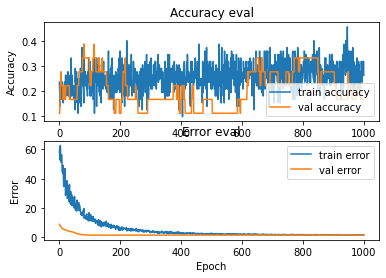

In [ ]:
fig, axs = plt.subplots(2)

# create accuracy sublpot
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="val accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# create error sublpot
axs[1].plot(history.history["loss"], label="train error")
axs[1].plot(history.history["val_loss"], label="val error")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")

plt.show()

# PREDICTION

In [ ]:
# perform prediction
prediction = model.predict(X_test)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Target: {}, Predicted label: {}".format(y_test, predicted_index))

Target: [[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]], Predicted label: [4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 3 4 3 4 4 3 4 4 4 3 4 4]


# TENSORBOARD

In [4]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [5]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 4258), started 0:25:38 ago. (Use '!kill 4258' to kill it.)

<IPython.core.display.Javascript object>

# RNN-LSTM MODEL

In [ ]:
DATA_PATH = r"data_voices.json"

with open(DATA_PATH, "r") as fp:
        data = json.load(fp)

# convert lists to numpy arrays
X = np.array(data["mfcc"],dtype=object)
y = np.array(data["labels"])


print("Data succesfully loaded!")

Data succesfully loaded!


In [ ]:
X = np.asarray(X).astype('float32')
y = to_categorical(y)

In [ ]:
TEST_SIZE = 0.25
VALIDATION_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=VALIDATION_SIZE)

In [ ]:
input_shape = (X_train.shape[1],X_train.shape[2])
model = keras.Sequential()

# RNN-LSTM LAYER
model.add(keras.layers.LSTM(64, input_shape=input_shape,return_sequences = True)) # sequence to sequence RNN modelini kullanıyoruz.
model.add(keras.layers.LSTM(64))

# DENSE LAYER
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dropout(0.4))

# OUTPUT LAYER
model.add(keras.layers.Dense(6,activation='softmax'))


In [ ]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
          loss='categorical_crossentropy',
          metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                    batch_size=32, 
                    epochs=200)

Epoch 1/200
3/3 [==============================] - 8s 982ms/step - loss: 1.8222 - accuracy: 0.1944 - val_loss: 1.7303 - val_accuracy: 0.2222
Epoch 2/200
3/3 [==============================] - 0s 23ms/step - loss: 1.7798 - accuracy: 0.2361 - val_loss: 1.7163 - val_accuracy: 0.3333
Epoch 3/200
3/3 [==============================] - 0s 22ms/step - loss: 1.7953 - accuracy: 0.2361 - val_loss: 1.7042 - val_accuracy: 0.3333
Epoch 4/200
3/3 [==============================] - 0s 23ms/step - loss: 1.7441 - accuracy: 0.3056 - val_loss: 1.6926 - val_accuracy: 0.3333
Epoch 5/200
3/3 [==============================] - 0s 23ms/step - loss: 1.7381 - accuracy: 0.2361 - val_loss: 1.6815 - val_accuracy: 0.3333
Epoch 6/200
3/3 [==============================] - 0s 23ms/step - loss: 1.7447 - accuracy: 0.2639 - val_loss: 1.6709 - val_accuracy: 0.2778
Epoch 7/200
3/3 [==============================] - 0s 27ms/step - loss: 1.6850 - accuracy: 0.3333 - val_loss: 1.6594 - val_accuracy: 0.2778
Epoch 8/200
3/3 [==

3/3 [==============================] - 0s 24ms/step - loss: 1.0962 - accuracy: 0.7361 - val_loss: 1.1490 - val_accuracy: 0.4444
Epoch 60/200
3/3 [==============================] - 0s 24ms/step - loss: 1.1201 - accuracy: 0.7083 - val_loss: 1.1350 - val_accuracy: 0.4444
Epoch 61/200
3/3 [==============================] - 0s 48ms/step - loss: 1.0671 - accuracy: 0.6944 - val_loss: 1.1168 - val_accuracy: 0.4444
Epoch 62/200
3/3 [==============================] - 0s 34ms/step - loss: 1.0489 - accuracy: 0.6944 - val_loss: 1.0983 - val_accuracy: 0.5556
Epoch 63/200
3/3 [==============================] - 0s 28ms/step - loss: 1.0302 - accuracy: 0.7361 - val_loss: 1.0813 - val_accuracy: 0.6111
Epoch 64/200
3/3 [==============================] - 0s 28ms/step - loss: 0.9839 - accuracy: 0.7778 - val_loss: 1.0673 - val_accuracy: 0.5556
Epoch 65/200
3/3 [==============================] - 0s 23ms/step - loss: 0.9905 - accuracy: 0.7361 - val_loss: 1.0556 - val_accuracy: 0.5000
Epoch 66/200
3/3 [========

3/3 [==============================] - 0s 23ms/step - loss: 0.3941 - accuracy: 0.9444 - val_loss: 0.5305 - val_accuracy: 0.8889
Epoch 118/200
3/3 [==============================] - 0s 23ms/step - loss: 0.2575 - accuracy: 0.9583 - val_loss: 0.5297 - val_accuracy: 0.8889
Epoch 119/200
3/3 [==============================] - 0s 21ms/step - loss: 0.2486 - accuracy: 0.9583 - val_loss: 0.5285 - val_accuracy: 0.8889
Epoch 120/200
3/3 [==============================] - 0s 25ms/step - loss: 0.3256 - accuracy: 0.9306 - val_loss: 0.5258 - val_accuracy: 0.8889
Epoch 121/200
3/3 [==============================] - 0s 25ms/step - loss: 0.3095 - accuracy: 0.9444 - val_loss: 0.5234 - val_accuracy: 0.8889
Epoch 122/200
3/3 [==============================] - 0s 26ms/step - loss: 0.3194 - accuracy: 0.9306 - val_loss: 0.5200 - val_accuracy: 0.8889
Epoch 123/200
3/3 [==============================] - 0s 23ms/step - loss: 0.3251 - accuracy: 0.9583 - val_loss: 0.5155 - val_accuracy: 0.8889
Epoch 124/200
3/3 [=

Epoch 175/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0884 - accuracy: 0.9861 - val_loss: 0.5412 - val_accuracy: 0.8889
Epoch 176/200
3/3 [==============================] - 0s 22ms/step - loss: 0.1215 - accuracy: 0.9861 - val_loss: 0.5455 - val_accuracy: 0.8889
Epoch 177/200
3/3 [==============================] - 0s 22ms/step - loss: 0.1126 - accuracy: 0.9861 - val_loss: 0.5488 - val_accuracy: 0.8889
Epoch 178/200
3/3 [==============================] - 0s 21ms/step - loss: 0.1080 - accuracy: 0.9583 - val_loss: 0.5517 - val_accuracy: 0.8889
Epoch 179/200
3/3 [==============================] - 0s 23ms/step - loss: 0.1238 - accuracy: 0.9722 - val_loss: 0.5542 - val_accuracy: 0.8889
Epoch 180/200
3/3 [==============================] - 0s 23ms/step - loss: 0.1152 - accuracy: 0.9861 - val_loss: 0.5558 - val_accuracy: 0.8889
Epoch 181/200
3/3 [==============================] - 0s 22ms/step - loss: 0.0951 - accuracy: 0.9861 - val_loss: 0.5568 - val_accuracy: 0.8889
Epoch 

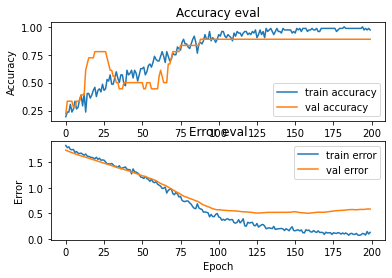

In [ ]:
fig, axs = plt.subplots(2)

# create accuracy sublpot
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="val accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# create error sublpot
axs[1].plot(history.history["loss"], label="train error")
axs[1].plot(history.history["val_loss"], label="val error")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")

plt.show()